# Dataset Information and Creation

This python notebook allow to better understand the dataset 'ECO', looking at what data is available, and then creating a new dataset that can be used to train a NILM model

## Imports

In [1]:
import numpy as np
from datetime import timedelta
from itertools import groupby
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Appliances and Power Metrics

In [2]:
# List of appliances per household
appliances_list_1 = ['Fridge', 'Dryer', 'Coffee Machine', 'Kettle', 'Washing Machine', 'PC', 'Freezer']
appliances_list_2 = ['Tablet', 'Dishwasher', 'Air Exhaust', 'Fridge', 'Entertainment', 'Freezer', 'Kettle', 'Lamp', 'Laptops', 'Stove', 'TV', 'Stereo']
appliances_list_3 = ['Tablet', 'Freezer', 'Coffee Machine', 'PC', 'Fridge', 'Kettle', 'Entertainment']
appliances_list_4 = ['Fridge', 'Kitchen Appliances', 'Lamp', 'Stereo and Laptop', 'Freezer', 'Tablet', 'Entertainment', 'Microwave']
appliances_list_5 = ['Tablet', 'Coffee Machine', 'Fountain', 'Microwave', 'Fridge', 'Entertainment', 'PC', 'Kettle']
appliances_list_6 = ['Lamp', 'Laptop', 'Router', 'Coffee Machine', 'Entertainment', 'Fridge', 'Kettle']

# Power metrics that are available
powers_list = [
    'powerallphases', 'powerl1', 'powerl2', 'powerl3',
    'currentneutral', 'currentl1', 'currentl2', 'currentl3',
    'voltagel1', 'voltagel2', 'voltagel3',
    'phaseanglevoltagel2l1', 'phaseanglevoltagel3l1',
    'phaseanglecurrentvoltagel1', 'phaseanglecurrentvoltagel2', 'phaseanglecurrentvoltagel3'
]

# Power metrics that are not used, not available through the smart meter
powers_list_drop = ['powerallphases', 'currentneutral', 'phaseanglevoltagel2l1', 'phaseanglevoltagel3l1', 'phaseanglecurrentvoltagel1', 'phaseanglecurrentvoltagel2', 'phaseanglecurrentvoltagel3']

dataset_path = 'dataset'

## Finding Common Date Ranges Across Folders

This function identifies all dates that are shared across multiple folders, assuming each folder contains
files named by date (in `YYYY-MM-DD` format). It then groups consecutive common dates into continuous
ranges for easier analysis. This is useful when working with time series data distributed across different
sources or categories, where only overlapping time periods are relevant.



In [3]:
def intersection_dates(ids, subfolder_list):
    # This will store one set of dates per folder
    all_date_sets = []

    for folder in subfolder_list:
        folder_path = os.path.join(ids, folder)
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        # Extract date from filenames
        file_dates = [pd.to_datetime(file.split('.')[0], format='%Y-%m-%d') for file in files]
        file_dates_set = set(file_dates)

        print(f"{folder} has {len(file_dates_set)} dates.")
        all_date_sets.append(file_dates_set)

    # Now find the common dates across all folders
    common_dates = set.intersection(*all_date_sets)
    common_dates = sorted(common_dates)

    # Group consecutive dates into ranges
    date_ranges = []
    if not common_dates:
        print("No common dates found across all folders.")
        return

    start_date = common_dates[0]
    for i in range(1, len(common_dates)):
        # If the next date is not the next day, store the current range
        if common_dates[i] != common_dates[i-1] + pd.Timedelta(days=1):
            end_date = common_dates[i-1]
            date_ranges.append((start_date, end_date))
            start_date = common_dates[i]

    # Add the last range
    date_ranges.append((start_date, common_dates[-1]))

    # Print the date ranges
    print(f"\nCommon date ranges across all folders: {len(date_ranges)}")
    for start, end in date_ranges:
        print(f"From {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    return date_ranges

## Checking Data Quality for a Single Day

This function checks whether a specific day's data for a given household is considered "clean" across a list
of appliances. It looks for long sequences of missing or invalid data (represented by `-1` values) in each
appliance's daily CSV file. If any such sequence exceeds a defined threshold (default: 30 samples), the day
is flagged as unclean and excluded from further analysis.

This helps ensure data reliability before performing time series analysis or machine learning tasks.


In [4]:
def is_day_clean(date, household_id, appliances_list_1, appliance_ids, threshold=30):
    for appliance, appliance_id in zip(appliances_list_1, appliance_ids):
        folder_path = os.path.join(household_id, appliance_id)
        file_name = f"{date.strftime('%Y-%m-%d')}.csv"
        file_path = os.path.join(folder_path, file_name)

        if not os.path.exists(file_path):
            continue

        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        for col in df.columns:
            if col.lower() in ['timestamp', 'time']:  # skip time column if present
                continue

            values = df[col].values
            for k, g in groupby(values):
                if k == -1 and len(list(g)) > threshold:
                    print(f"Long -1 sequence in {file_name} ({appliance}) — removing this day")
                    return False

    return True


## Filtering for Clean Date Ranges

This function refines a list of candidate date ranges by checking each day individually for data quality
(using the `is_day_clean` function). Only days that pass the quality check are retained. It then reconstructs
new, continuous date ranges made up exclusively of clean days.

This step ensures that subsequent analyses are based only on reliable, uninterrupted data, and also
highlights the longest stretch of clean data available for the household.


In [5]:
def clean_dates(dates):
    if not dates:
        print("No valid dates found.")
        return
    # Step 1: Collect all valid dates
    clean_days = []

    for start_date, end_date in dates:
        current_day = start_date
        while current_day <= end_date:
            if is_day_clean(current_day, household_id, appliances_list_1, appliance_ids):
                clean_days.append(current_day)
            current_day += timedelta(days=1)

    # Step 2: Rebuild clean date ranges
    clean_days.sort()
    clean_ranges = []
    if clean_days:
        range_start = clean_days[0]
        range_end = clean_days[0]

        for i in range(1, len(clean_days)):
            if clean_days[i] == range_end + timedelta(days=1):
                range_end = clean_days[i]
            else:
                clean_ranges.append((range_start, range_end))
                range_start = clean_days[i]
                range_end = clean_days[i]
        clean_ranges.append((range_start, range_end))

    # Step 3: Print the clean ranges
    print("\nClean date ranges:")
    for start, end in clean_ranges:
        print(f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    if not clean_ranges:
        print("No clean ranges found.")
        return

    # Show the longest clean range
    longest_range = max(clean_ranges, key=lambda x: (x[1] - x[0]).days)
    print(f"Longest clean range: {longest_range[0].strftime('%Y-%m-%d')} to {longest_range[1].strftime('%Y-%m-%d')}")

    print(f"\nHousehold {household_id}: {len(clean_days)} clean days.")

    return clean_ranges

## Interpolating Missing Values in a Day

This function handles short sequences of missing values (represented by `-1`) in a day's data by interpolating
them, using a specified method (default: linear). It temporarily treats `-1` values as missing (`NaN`), performs
interpolation within a defined gap limit (default: 30), and restores the original structure for values that
could not be filled.

This is useful for preserving time series continuity while avoiding overfitting or distortion from long gaps.


In [6]:
def interpolate_day_from_minus1(df, method='linear', limit=30):
    # Only replace -1s temporarily for interpolation
    mask = (df == -1)

    # Convert -1 to a temporary NaN for interpolation
    df_interp = df.mask(mask)

    # Interpolate along columns (time-based axis), limited to small gaps
    df_interp = df_interp.interpolate(method=method, axis=0, limit=limit, limit_direction='both')

    # Restore the structure: if interpolation didn’t fix some -1s, put them back
    df_filled = df.where(~mask, df_interp)

    return df_filled


## Saving and Resampling Cleaned Appliance Data

This function loads and processes daily data for a given household across multiple appliances and a specified
date range. For each valid day:

- It reads the corresponding CSV files (one per appliance),
- Interpolates missing values (`-1`) using `interpolate_day_from_minus1`,
- Merges all appliance data into a single DataFrame,
- Resamples the data to 10-second intervals for uniformity,
- Optionally saves the cleaned dataset to a `.parquet` file.

The result is a time-aligned, cleaned, and resampled dataset suitable for further analysis or modeling.


In [7]:
def save_data(column_names, date_range, house_id, apps_id, sm_columns, save_to_file=False):
    all_data = []  # List of daily DataFrames to concat at the end

    for start_date, end_date in date_range:
        current_day = start_date
        while current_day <= end_date:
            day_data = pd.DataFrame()  # New DataFrame for one day

            for appliance, appliance_id in zip(column_names, apps_id):
                folder_path = f'{house_id}/{appliance_id}'
                file_name = f"{current_day.strftime('%Y-%m-%d')}.csv"
                file_path = os.path.join(folder_path, file_name)

                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    continue

                try:
                    read_df = pd.read_csv(file_path, header=None)

                    if len(read_df) == 86400:
                        # interpolate missing values
                        read_df = interpolate_day_from_minus1(read_df)

                        if appliance_id == "sm":
                            # Handle multiple columns for smart meter
                            if read_df.shape[1] != len(sm_columns):
                                print(f"Warning: smart meter columns mismatch in {file_path} — expected {len(sm_columns)}, got {read_df.shape[1]}")
                                continue

                            read_df.columns = sm_columns
                            for col in sm_columns:
                                day_data[col] = read_df[col].values
                        else:
                            # Single-column appliance
                            if appliance != 'Smart Meter':
                                day_data[appliance] = read_df[0].values
                            else:
                                print('Appliance is smart meter')
                    else:
                        print(f"Skipping {file_path}: expected 86400 rows, got {len(read_df)}")

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

            if not day_data.empty:
                # Generate timestamp column and insert as first column
                timestamps = pd.date_range(
                    start=current_day, periods=86400, freq='s'
                )
                day_data.insert(0, 'timestamp', timestamps)
                day_data.insert(1, 'household_id', house_id)

                # Resample the data every 10s
                # Ensure timestamp is set as index for resampling
                day_data.set_index('timestamp', inplace=True)
                # Select only numeric columns
                numeric_columns = day_data.select_dtypes(include=[np.number]).columns
                day_data_numeric = day_data[numeric_columns]
                # Resample every 10 seconds, taking the mean
                day_data_resampled = day_data_numeric.resample('10s').mean().interpolate(method='linear')
                # Restore the timestamp column and reset index
                day_data_resampled.reset_index(inplace=True)
                # Add household_id back
                day_data_resampled['household_id'] = house_id

                # Append to list
                all_data.append(day_data_resampled)

            current_day += pd.Timedelta(days=1)

    # Combine all days into one big DataFrame
    df = pd.concat(all_data, ignore_index=True)

    print(df.head())
    if save_to_file:
        df.to_parquet(f"cleaned_data/{house_id}.parquet", index=False)
    else:
        return df

## Household 1

In [8]:
household_id = "01"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_1) + 1)]
appliance_ids.append('sm')
appliances_list_1.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print("\nRemoving appliance 06")
appliance_ids.remove('06')
appliances_list_1.remove('PC')
dates_1 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print("\nCleaning dates")
clean_range_1 = clean_dates(dates_1)

print("\nSaving data")
df_1 = save_data(appliances_list_1, clean_range_1, os.path.join(dataset_path, household_id), appliance_ids, powers_list)

01 has 231 dates.
02 has 231 dates.
03 has 113 dates.
04 has 203 dates.
05 has 231 dates.
06 has 66 dates.
07 has 231 dates.
sm has 245 dates.
No common dates found across all folders.

Removing appliance 06
01 has 231 dates.
02 has 231 dates.
03 has 113 dates.
04 has 203 dates.
05 has 231 dates.
07 has 231 dates.
sm has 245 dates.

Common date ranges across all folders: 7
From 2012-09-15 to 2012-10-16
From 2012-10-23 to 2012-11-16
From 2012-11-23 to 2012-11-27
From 2012-11-29 to 2012-11-30
From 2012-12-04 to 2012-12-09
From 2012-12-13 to 2012-12-16
From 2012-12-22 to 2013-01-23

Cleaning dates

Clean date ranges:
2012-09-15 to 2012-10-16
2012-10-23 to 2012-11-16
2012-11-23 to 2012-11-27
2012-11-29 to 2012-11-30
2012-12-04 to 2012-12-09
2012-12-13 to 2012-12-16
2012-12-22 to 2013-01-23
Longest clean range: 2012-12-22 to 2013-01-23

Household 01: 107 clean days.

Saving data
            timestamp  Fridge  Dryer  Coffee Machine  Kettle  Washing Machine  \
0 2012-09-15 00:00:00     NaN   

## Household 2

In [9]:
household_id = "02"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_2) + 1)]
appliance_ids.append('sm')
appliances_list_2.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print()
print("Removing appliance 10")
appliance_ids.remove('10')
appliances_list_2.remove('Stove')
dates_2 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_2 = clean_dates(dates_2)
print("\nSaving data")
df_2 = save_data(appliances_list_2, clean_range_2, os.path.join(dataset_path, household_id), appliance_ids, powers_list)

01 has 240 dates.
02 has 240 dates.
03 has 240 dates.
04 has 240 dates.
05 has 236 dates.
06 has 240 dates.
07 has 240 dates.
08 has 240 dates.
09 has 240 dates.
10 has 28 dates.
11 has 240 dates.
12 has 240 dates.
sm has 244 dates.

Common date ranges across all folders: 10
From 2012-06-02 to 2012-06-07
From 2012-06-10 to 2012-06-13
From 2012-06-16 to 2012-06-18
From 2012-06-20 to 2012-06-20
From 2012-07-01 to 2012-07-01
From 2012-07-04 to 2012-07-05
From 2012-07-07 to 2012-07-08
From 2012-07-10 to 2012-07-11
From 2012-07-13 to 2012-07-17
From 2012-07-19 to 2012-07-20

Removing appliance 10
01 has 240 dates.
02 has 240 dates.
03 has 240 dates.
04 has 240 dates.
05 has 236 dates.
06 has 240 dates.
07 has 240 dates.
08 has 240 dates.
09 has 240 dates.
11 has 240 dates.
12 has 240 dates.
sm has 244 dates.

Common date ranges across all folders: 5
From 2012-06-01 to 2012-09-04
From 2012-09-08 to 2012-09-13
From 2012-09-15 to 2012-11-02
From 2012-11-07 to 2012-11-27
From 2012-11-29 to 2013

## Household 3

In [10]:
household_id = "03"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_3) + 1)]
appliance_ids.append('sm')
appliances_list_3.append("Smart Meter")

dates_3 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_3 = clean_dates(dates_3)
# print("\nSaving data")
# save_data_to_csv(appliances_list_3, clean_range_3, household_id, appliance_ids)

01 has 97 dates.
02 has 97 dates.
03 has 60 dates.
04 has 35 dates.
05 has 41 dates.
06 has 36 dates.
07 has 45 dates.
sm has 138 dates.

Common date ranges across all folders: 2
From 2012-12-06 to 2012-12-06
From 2012-12-30 to 2012-12-30

Cleaning dates

Clean date ranges:
2012-12-06 to 2012-12-06
2012-12-30 to 2012-12-30
Longest clean range: 2012-12-06 to 2012-12-06

Household 03: 2 clean days.


## Household 4

In [11]:
household_id = "04"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_4) + 1)]
appliance_ids.append('sm')
appliances_list_4.append("Smart Meter")

dates_4 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_4 = clean_dates(dates_4)
print("\nSaving data")
df_4 = save_data(appliances_list_4, clean_range_4, os.path.join(dataset_path, household_id), appliance_ids, powers_list)

01 has 194 dates.
02 has 194 dates.
03 has 170 dates.
04 has 169 dates.
05 has 192 dates.
06 has 189 dates.
07 has 186 dates.
08 has 195 dates.
sm has 219 dates.

Common date ranges across all folders: 7
From 2012-06-27 to 2012-07-14
From 2012-07-23 to 2012-09-05
From 2012-09-11 to 2012-10-20
From 2012-11-09 to 2012-11-10
From 2012-11-14 to 2012-11-16
From 2012-12-01 to 2012-12-22
From 2012-12-24 to 2013-01-13

Cleaning dates

Clean date ranges:
2012-06-27 to 2012-07-14
2012-07-23 to 2012-09-05
2012-09-11 to 2012-10-20
2012-11-09 to 2012-11-10
2012-11-14 to 2012-11-16
2012-12-01 to 2012-12-22
2012-12-24 to 2013-01-13
Longest clean range: 2012-07-23 to 2012-09-05

Household 04: 151 clean days.

Saving data
            timestamp    Fridge  Kitchen Appliances      Lamp  \
0 2012-06-27 00:00:00  101.1492            0.649548  1.119890   
1 2012-06-27 00:00:10  100.2960            0.000000  2.015802   
2 2012-06-27 00:00:20  100.7226            0.433032  0.671934   
3 2012-06-27 00:00:30  10

## Household 5

In [12]:
household_id = "05"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_5) + 1)]
appliance_ids.append('sm')
appliances_list_5.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print()
print("Removing appliance 03")
print("Removing appliance 08")
appliance_ids.remove('03')
appliance_ids.remove('08')
appliances_list_5.remove('Fountain')
appliances_list_5.remove('Kettle')

dates_5 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_5 = clean_dates(dates_5)
print("\nSaving data")
df_5 = save_data(appliances_list_5, clean_range_5, os.path.join(dataset_path, household_id), appliance_ids, powers_list)

01 has 218 dates.
02 has 218 dates.
03 has 71 dates.
04 has 218 dates.
05 has 218 dates.
06 has 192 dates.
07 has 218 dates.
08 has 25 dates.
sm has 215 dates.
No common dates found across all folders.

Removing appliance 03
Removing appliance 08
01 has 218 dates.
02 has 218 dates.
04 has 218 dates.
05 has 218 dates.
06 has 192 dates.
07 has 218 dates.
sm has 215 dates.

Common date ranges across all folders: 6
From 2012-06-27 to 2012-08-10
From 2012-09-04 to 2012-09-06
From 2012-09-11 to 2012-10-15
From 2012-10-17 to 2012-11-27
From 2012-11-29 to 2012-12-20
From 2012-12-22 to 2013-01-31

Cleaning dates

Clean date ranges:
2012-06-27 to 2012-08-10
2012-09-04 to 2012-09-06
2012-09-11 to 2012-10-15
2012-10-17 to 2012-11-27
2012-11-29 to 2012-12-20
2012-12-22 to 2013-01-31
Longest clean range: 2012-06-27 to 2012-08-10

Household 05: 188 clean days.

Saving data
            timestamp    Tablet  Coffee Machine  Microwave    Fridge  \
0 2012-06-27 00:00:00  3.270135        3.845252   5.08388

## Household 6

In [13]:
household_id = "06"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_6) + 1)]
appliance_ids.append('sm')
appliances_list_6.append("Smart Meter")

dates_6 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_6 = clean_dates(dates_6)
print("\nSaving data")
df_6 = save_data(appliances_list_6, clean_range_6, os.path.join(dataset_path, household_id), appliance_ids, powers_list)

01 has 166 dates.
02 has 185 dates.
03 has 88 dates.
04 has 179 dates.
05 has 181 dates.
06 has 179 dates.
07 has 147 dates.
sm has 166 dates.

Common date ranges across all folders: 4
From 2012-06-27 to 2012-08-25
From 2012-08-30 to 2012-08-30
From 2012-09-03 to 2012-09-08
From 2012-09-17 to 2012-09-22

Cleaning dates

Clean date ranges:
2012-06-27 to 2012-08-25
2012-08-30 to 2012-08-30
2012-09-03 to 2012-09-08
2012-09-17 to 2012-09-22
Longest clean range: 2012-06-27 to 2012-08-25

Household 06: 73 clean days.

Saving data
            timestamp  Lamp    Laptop    Router  Coffee Machine  \
0 2012-06-27 00:00:00   0.0  5.204284  19.55193             0.0   
1 2012-06-27 00:00:10   0.0  5.416895  19.97839             0.0   
2 2012-06-27 00:00:20   0.0  5.204284  19.97839             0.0   
3 2012-06-27 00:00:30   0.0  5.416895  19.76516             0.0   
4 2012-06-27 00:00:40   0.0  5.629506  19.76516             0.0   

   Entertainment    Fridge  Kettle  powerallphases  powerl1  ...  c

## Creating a single dataframe for all households

In [14]:
# Concatenate all DataFrames into one
dataframes = [df_1, df_2, df_4, df_5, df_6]
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.head())

# Combine appliance lists
all_appliances = appliances_list_1 + appliances_list_2 + appliances_list_4 + appliances_list_5 + appliances_list_6
print(all_appliances)

# Remove duplicates and sort the list
unique_appliances = list(set(all_appliances))
unique_appliances.remove('Smart Meter')
unique_appliances = sorted(unique_appliances)
print(unique_appliances)

desired_order = ['timestamp', 'household_id'] + powers_list + unique_appliances

combined_df = combined_df[desired_order]

# Drop unnecessary columns
combined_df.drop(columns=powers_list_drop, inplace=True)

# Replace NaN values with 0 for missing appliance data
combined_df = combined_df.fillna(0)

            timestamp  Fridge  Dryer  Coffee Machine  Kettle  Washing Machine  \
0 2012-09-15 00:00:00     NaN    NaN             NaN     NaN              NaN   
1 2012-09-15 00:00:10     NaN    NaN             NaN     NaN              NaN   
2 2012-09-15 00:00:20     NaN    NaN             NaN     NaN              NaN   
3 2012-09-15 00:00:30     NaN    NaN             NaN     NaN              NaN   
4 2012-09-15 00:00:40     NaN    NaN             NaN     NaN              NaN   

   Freezer  powerallphases  powerl1  powerl2  ...  Lamp  Laptops  TV  Stereo  \
0      NaN         88.2724  59.5912  18.8788  ...   NaN      NaN NaN     NaN   
1      NaN         88.3384  59.5669  18.8937  ...   NaN      NaN NaN     NaN   
2      NaN         88.1482  59.4951  18.8313  ...   NaN      NaN NaN     NaN   
3      NaN         88.2964  59.5508  18.8299  ...   NaN      NaN NaN     NaN   
4      NaN         88.3211  59.5986  18.8231  ...   NaN      NaN NaN     NaN   

   Kitchen Appliances  Stereo an

## Final Checks and Appliance Balancing

This section performs quality control and balances the dataset before analysis:

- **Sanity Checks**: Verifies that no `-1` values or `NaN` entries remain in the combined DataFrame.
- **Appliance Activity Check**: Counts how often each appliance registers a non-zero value, giving a sense of usage balance across appliances.
- **Column Cleanup**: Allows for optional removal of unused or irrelevant appliance columns.
- **Appliance List Update**: Ensures that the list of active appliances matches the cleaned dataset.

This step ensures that the dataset is clean, consistent, and limited to meaningful appliances for analysis.


In [15]:
# check if -1 value is in df
print("Checking for -1 values in the DataFrame (should be 0):")
print((combined_df == -1).sum().sum())
# check if there are any missing values
print("Checking for missing values in the DataFrame (should be 0):")
print(combined_df.isnull().sum().sum())

# Find balance between appliances
appliance_counts = combined_df[unique_appliances].gt(0).sum()
print("Counts of appliances with non-zero values:")
print(appliance_counts)

# Drop useless appliances columns
remove_appliances = ['Kettle', 'Kitchen Appliances', 'Laptops', 'Stereo and Laptop', 'Air Exhaust', 'Entertainment']
combined_df.drop(columns=remove_appliances, inplace=True)

print(combined_df.columns)

# Remove remove_appliances from unique_appliances
for appliance in remove_appliances:
    if appliance in unique_appliances:
        unique_appliances.remove(appliance)

print(unique_appliances)

# Find balance between appliances
appliance_counts = combined_df[unique_appliances].gt(0).sum()
print("Counts of appliances with non-zero values:")
print(appliance_counts)

Checking for -1 values in the DataFrame (should be 0):
0
Checking for missing values in the DataFrame (should be 0):
0
Counts of appliances with non-zero values:
Air Exhaust             57698
Coffee Machine         236008
Dishwasher             154870
Dryer                  267886
Entertainment         5312068
Freezer               3184993
Fridge                5630114
Kettle                  10279
Kitchen Appliances    1073262
Lamp                  1580722
Laptop                 629527
Laptops                495892
Microwave             2897067
PC                    1603555
Router                 630105
Stereo                1936472
Stereo and Laptop      945776
TV                     485298
Tablet                4649982
Washing Machine        469582
dtype: int64
Index(['timestamp', 'household_id', 'powerl1', 'powerl2', 'powerl3',
       'currentl1', 'currentl2', 'currentl3', 'voltagel1', 'voltagel2',
       'voltagel3', 'Coffee Machine', 'Dishwasher', 'Dryer', 'Freezer',
       'Frid

## Appliance Zero-Value Analysis

This section computes the **percentage of zero values** for each appliance across all timestamps:

- Helps identify appliances with **little to no activity**.
- Useful for **filtering out inactive or irrelevant appliances** from the analysis.
- Percentages are sorted in descending order to highlight the least active appliances.

This metric supports informed decisions on which appliances may be excluded to reduce data noise or improve model focus.


In [16]:
# Show percentage of 0 value for each appliance over the total of that appliance
# Count total entries per appliance
total_counts = combined_df[unique_appliances].shape[0]

# Count how many values are 0 for each appliance
zero_counts = (combined_df[unique_appliances] == 0).sum()

# Calculate percentage of zero values
zero_percentage = (zero_counts / total_counts) * 100

# Display nicely
print("Percentage of zeros:")
print(zero_percentage.sort_values(ascending=False).round(2).astype(str) + ' %')

Percentage of zeros:
Dishwasher         97.63 %
Coffee Machine     96.38 %
Dryer              95.89 %
Washing Machine     92.8 %
TV                 92.56 %
Laptop             90.35 %
Router             90.34 %
Lamp               75.77 %
PC                 75.42 %
Stereo             70.31 %
Microwave          55.59 %
Freezer            51.17 %
Tablet             28.72 %
Fridge             13.69 %
dtype: object


## Plotting the distribution of appliances

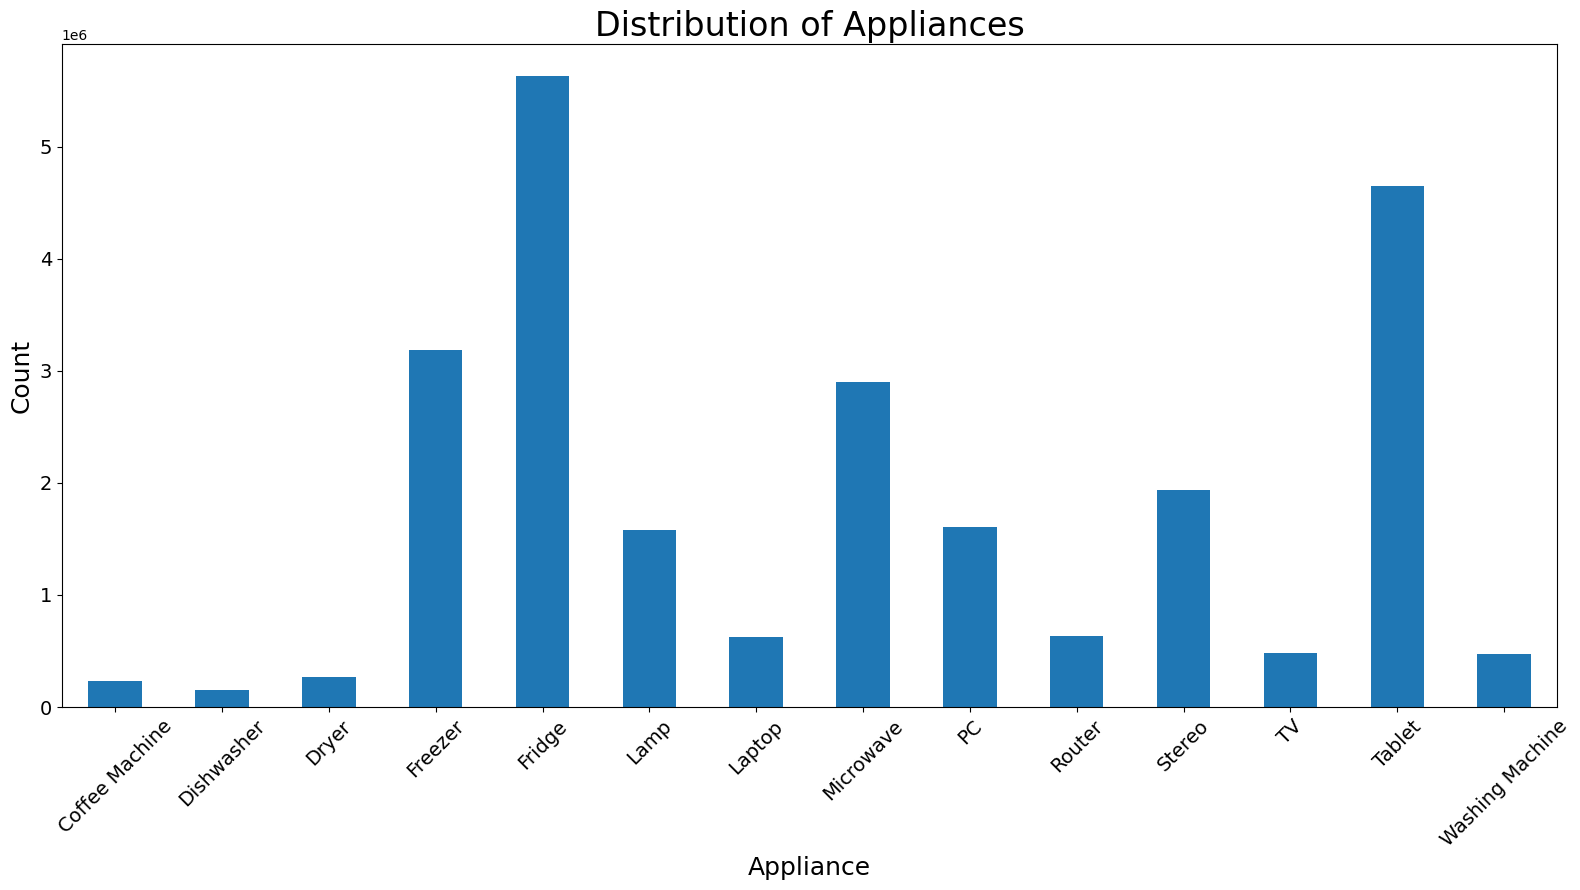

In [17]:
# Check the distribution of appliances
appliance_counts.plot(kind='bar', figsize=(16, 9))
plt.title('Distribution of Appliances', fontsize=24)
plt.xlabel('Appliance', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save figure
# plt.savefig('appliance_distribution.png', dpi=300, bbox_inches='tight')

plt.show()


## Plot the first 1000 points of each appliance

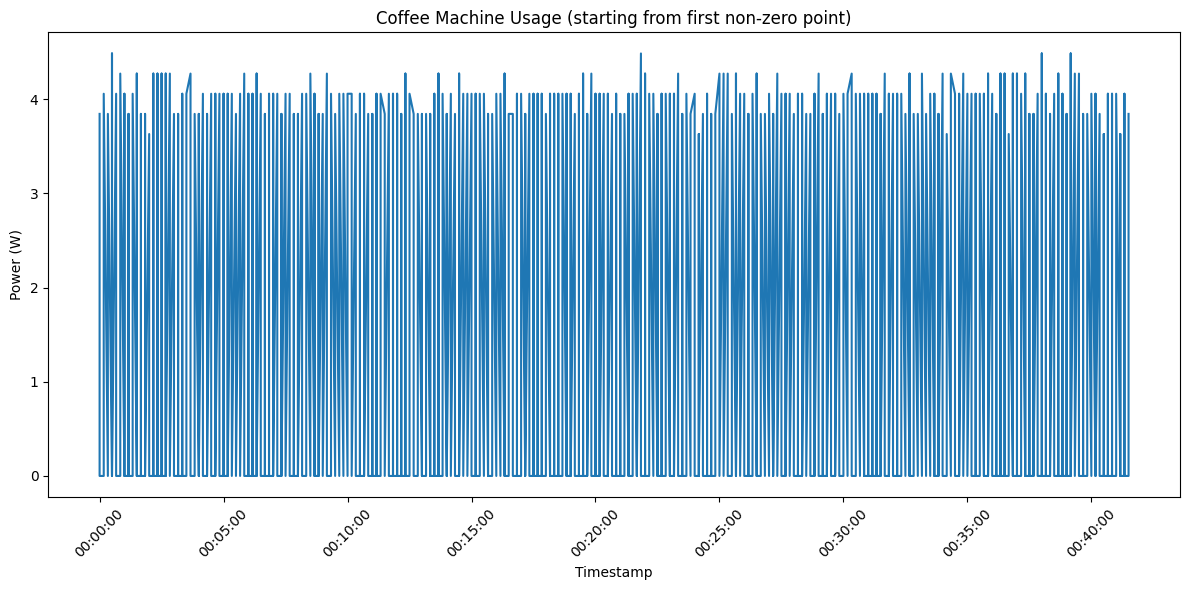

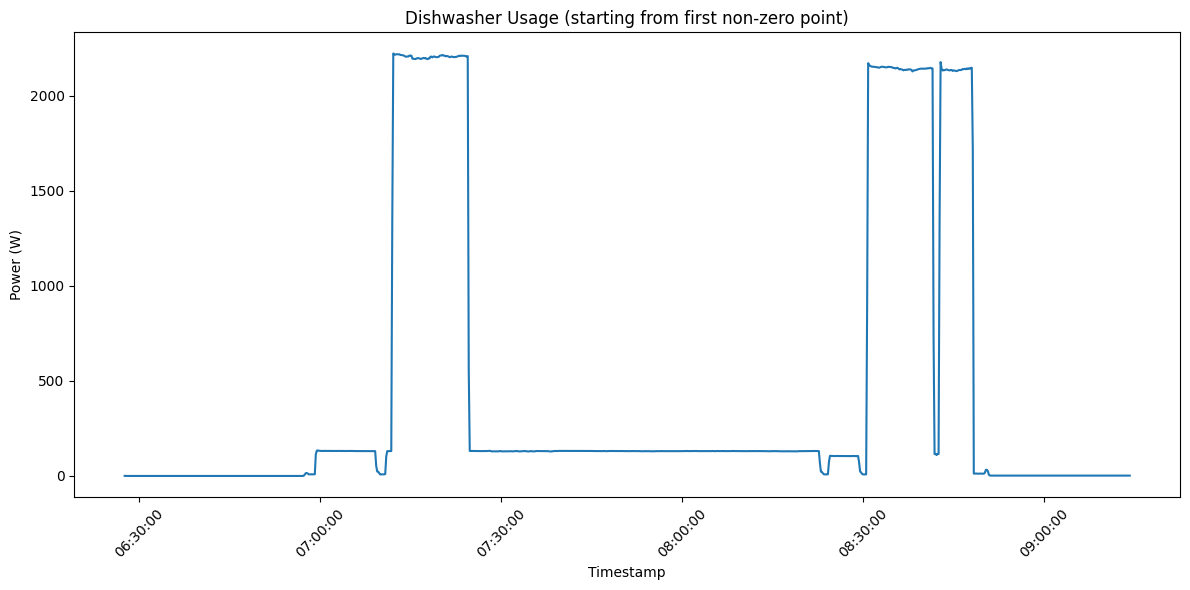

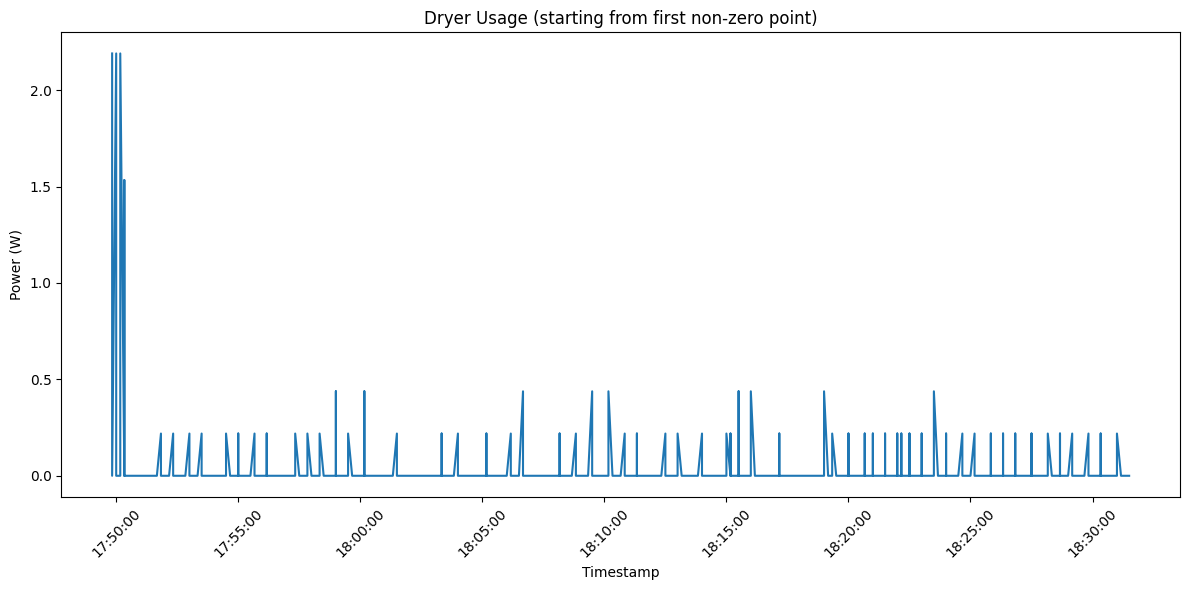

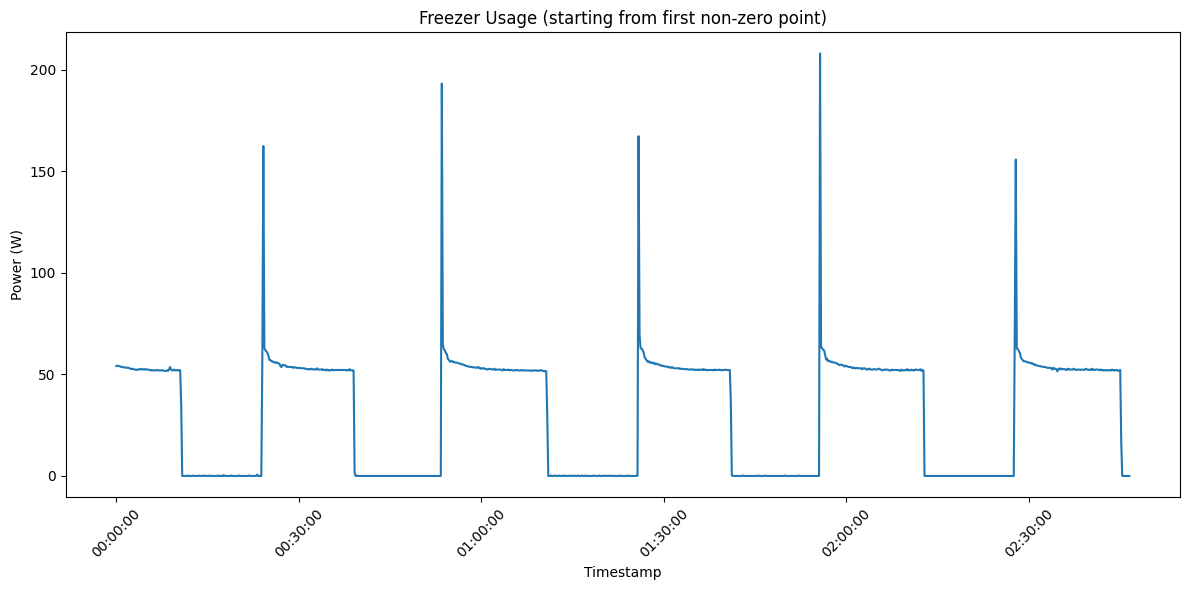

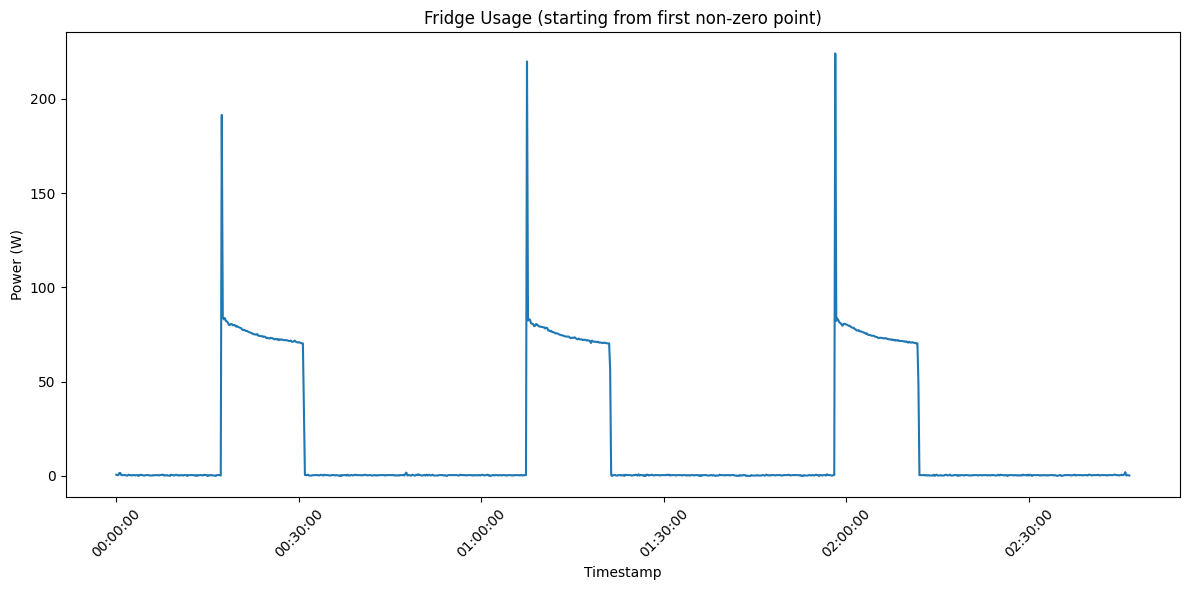

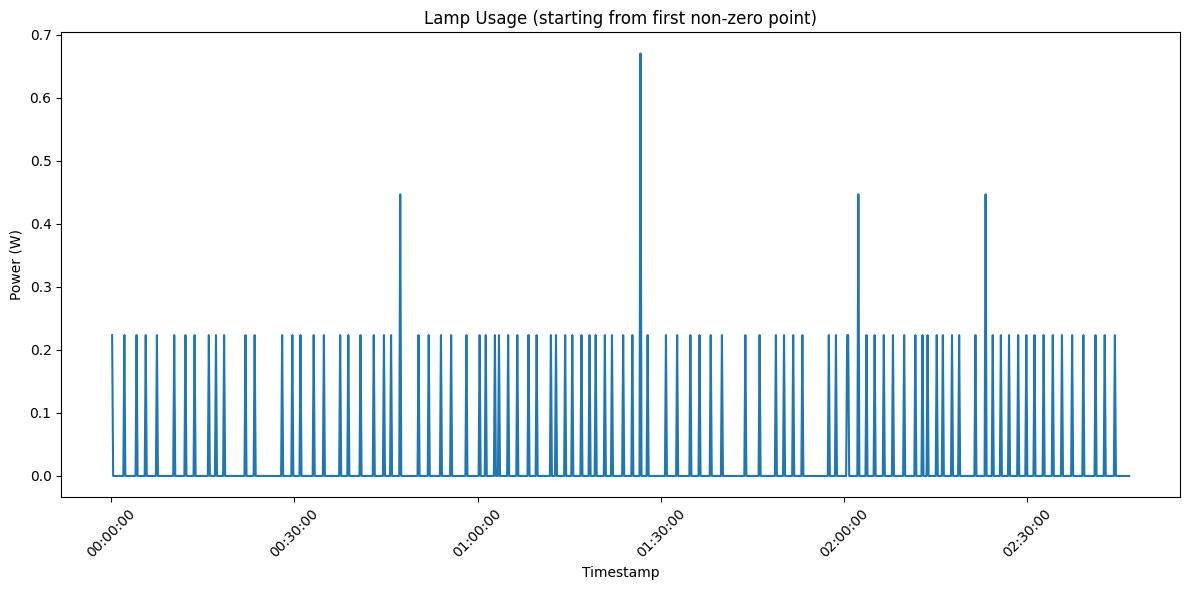

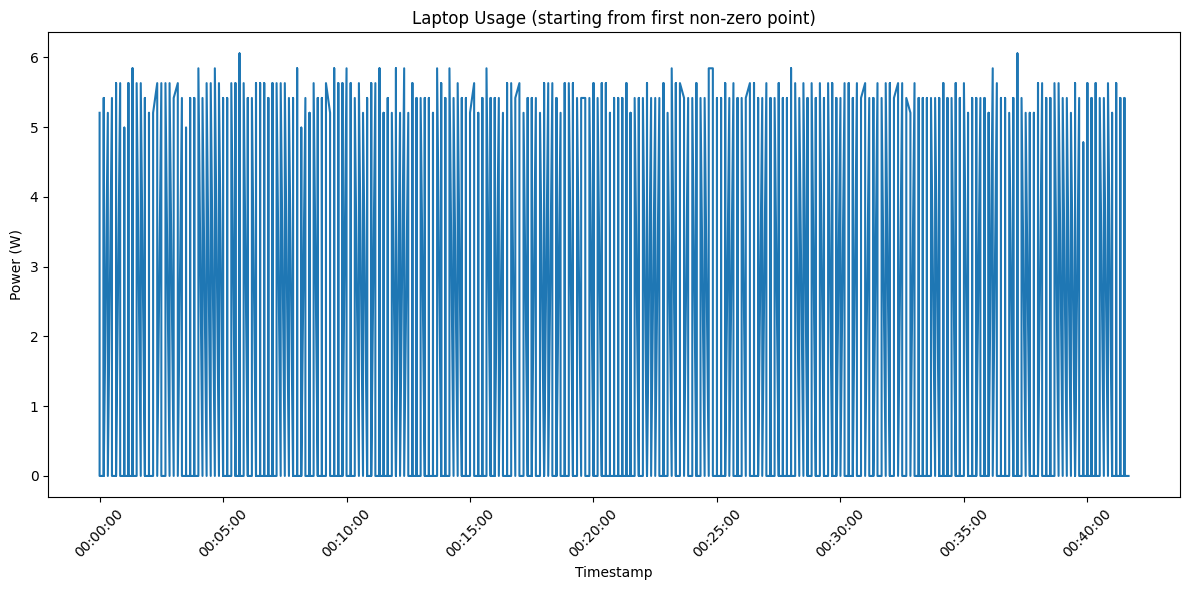

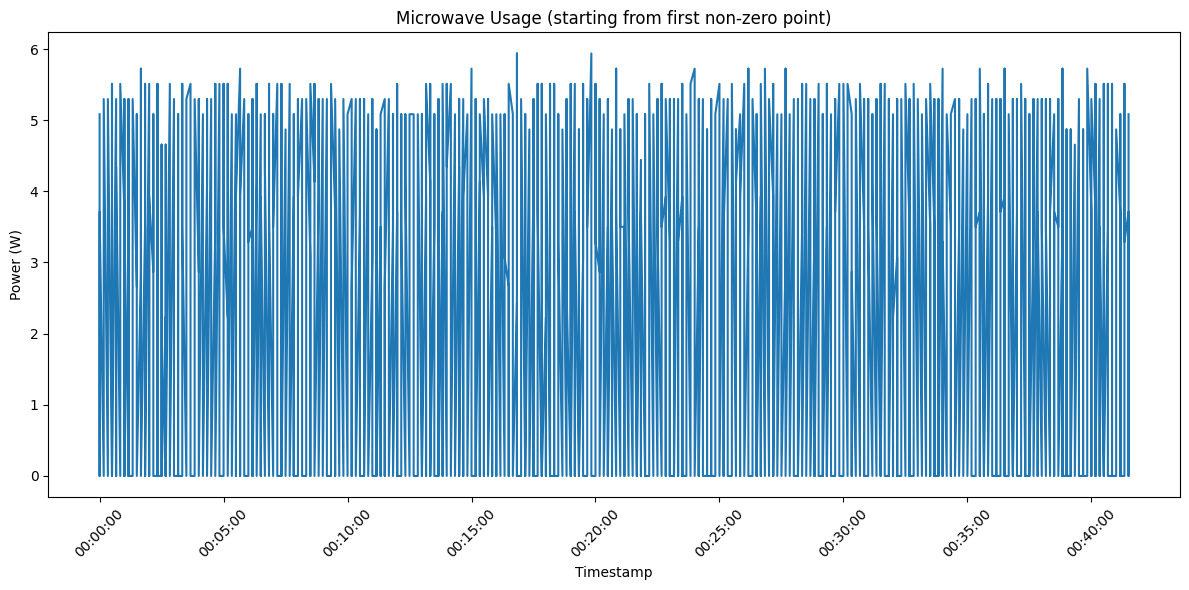

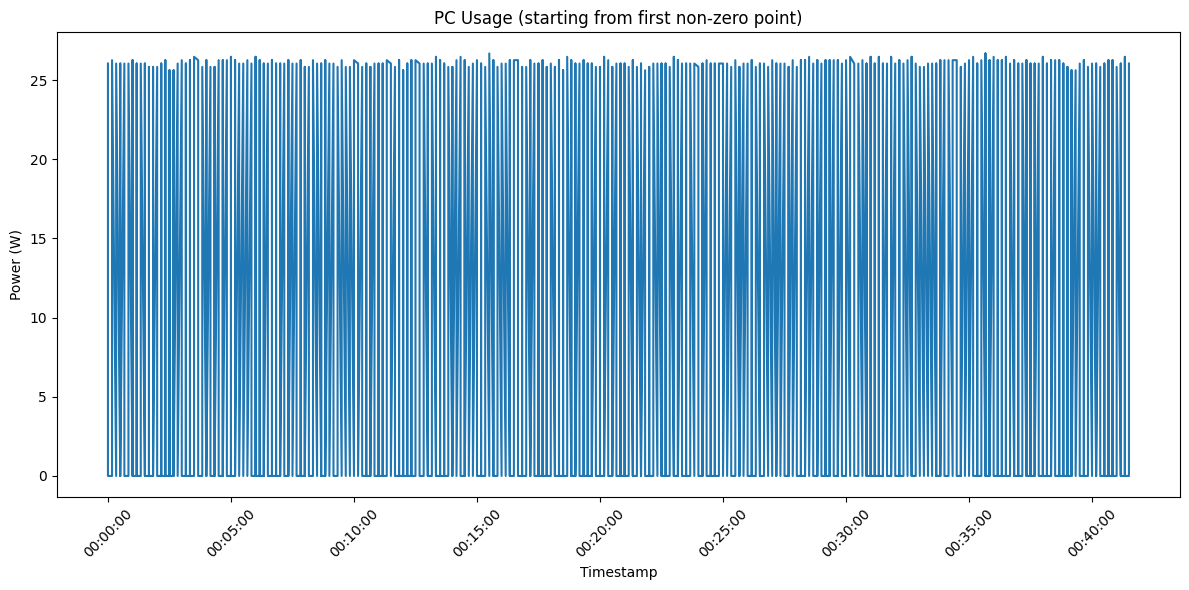

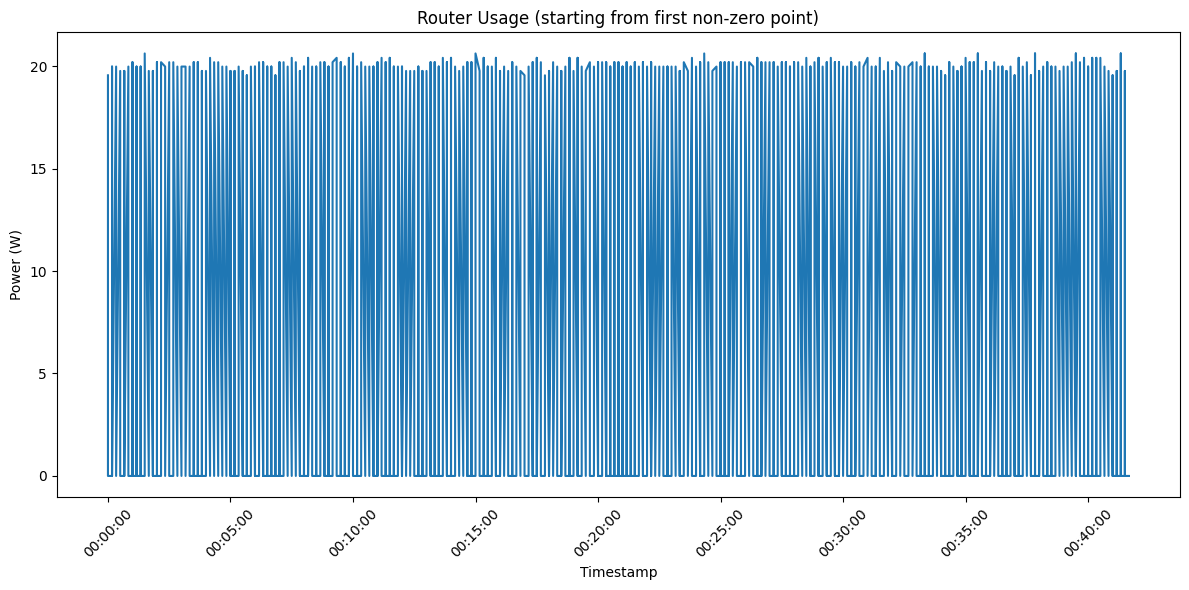

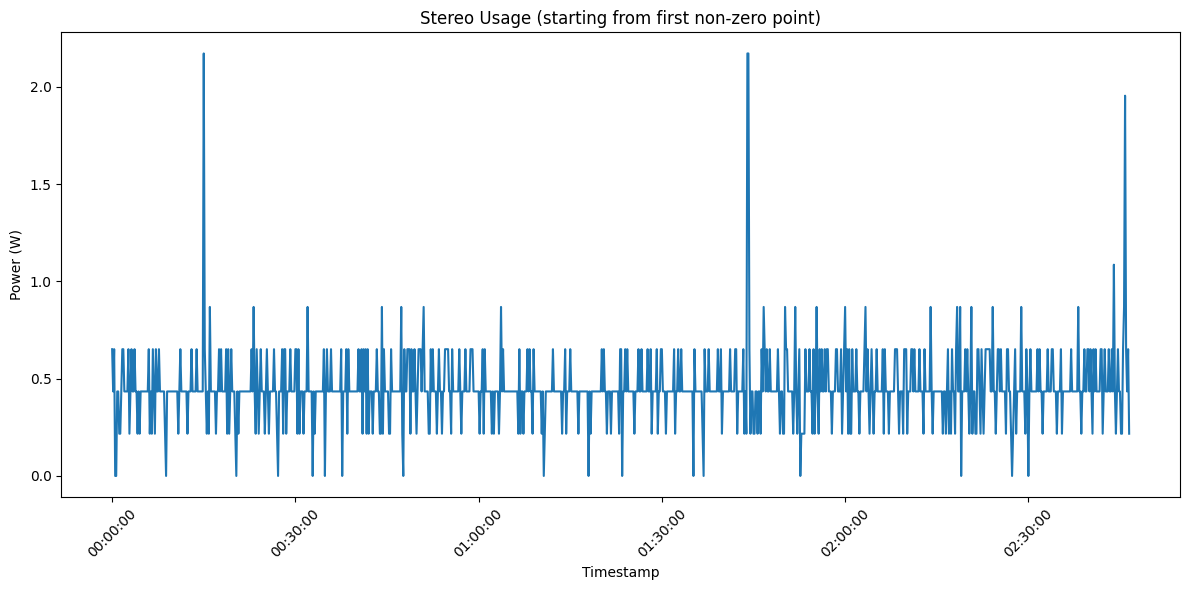

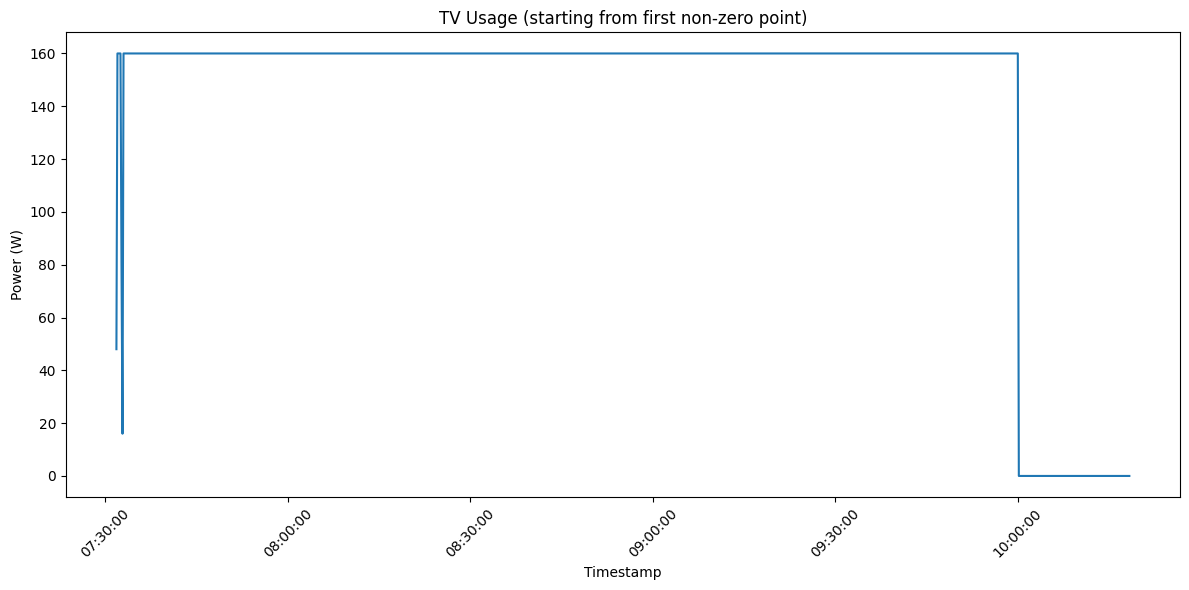

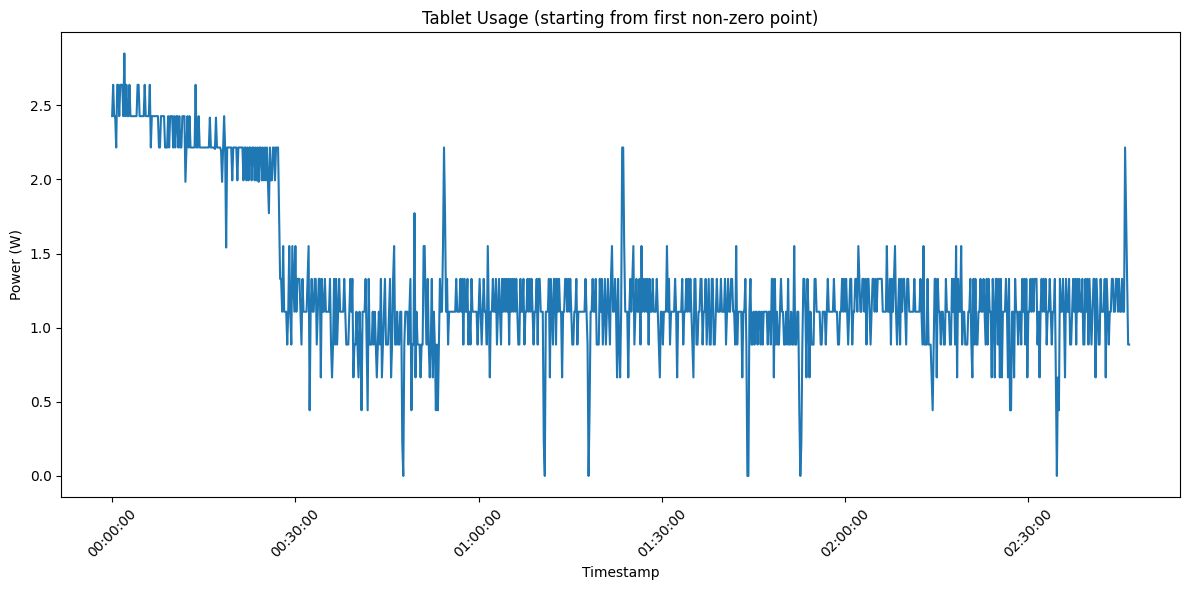

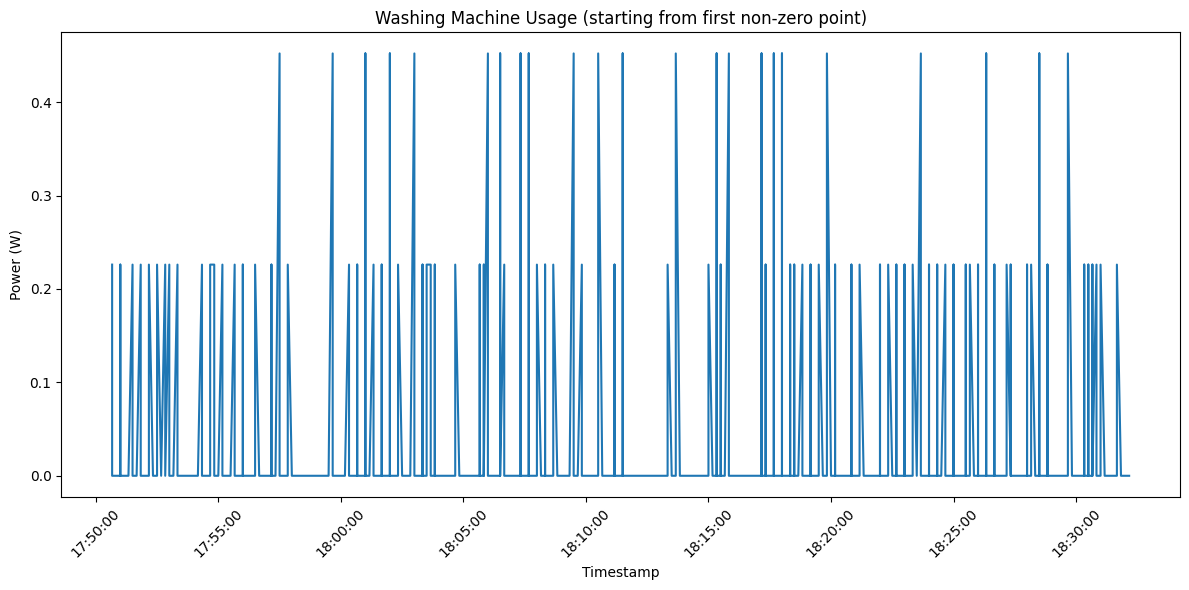

In [18]:
# Parse & clean timestamp
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')
df = combined_df.dropna(subset=['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

for appliance in unique_appliances:
    # Find the index of the first non-zero value
    non_zero_indices = df.index[df[appliance] > 0].tolist()

    if non_zero_indices:
        start_idx = non_zero_indices[0]
        end_idx = start_idx + 1000
        active_data = df.iloc[start_idx:end_idx][['timestamp', appliance]]

        plt.figure(figsize=(12, 6))
        plt.plot(active_data['timestamp'], active_data[appliance])
        plt.title(f'{appliance} Usage (starting from first non-zero point)')
        plt.xlabel('Timestamp')
        plt.ylabel('Power (W)')

        # Format X-axis ticks
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Save the dataframe to parquet file

In [19]:
# Save the cleaned DataFrame to a parquet file
combined_df.to_parquet('combined_data.parquet', index=False)

# Show file weight
print(f"File size: {os.path.getsize('combined_data.parquet') / (1024 * 1024):.2f} MB")

File size: 233.18 MB
